Вычисляет оценку **BLEU-2** для сгенерированной последовательности.
Использует сглаживание для предотвращения нулевой оценки при отсутствии совпадений.

**Метрика:** BLEU (Bilingual Evaluation Understudy)
**Назначение:** Оценивает сходство сгенерированного текста с эталонным. Для символьного уровня сравнивает совпадение пар (2-грамм) символов, а не слов, что менее информативно, чем для слов.

**Weights=(0.5, 0.5):** Означает, что используются отдельные символы и пары символов с равным весом.

---

**clean_text:** Предварительная обработка текста: приведение к нижнему регистру,удаление всех символов, кроме кириллицы, латиницы, пробелов и основных знаков препинания. Очистка необходима для формирования чистого словаря символов (VOCAB).

SEQUENCE_LENGTH  Максимальная длина последовательности символов

EMBEDDING_DIM    Размерность векторного представления символа

MODEL_DIM        Размерность модели

NUM_HEADS        Количество "голов" в Multi-Head Attention

NUM_LAYERS       Количество слоев декодера

FF_DIM           Размерность скрытого слоя Feed-Forward

LEARNING_RATE    Скорость обучения

NUM_EPOCHS       Количество эпох

BATCH_SIZE       Вводим батчи для Transformer

TEST_FRAGMENT_LENGTH Длина сгенерированного фрагмента

START_TOKEN      Токен начала последовательности

PAD_TOKEN        Токен заполнения

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import collections
import matplotlib.pyplot as plt
import numpy as np

# Вспомогательные функции
def calculate_bleu2(reference_words, generated_words):
    if len(generated_words) < 2:
        return 0.0
    chencherry = SmoothingFunction()
    # Сравнение биграмм и униграмм символов
    score = sentence_bleu([reference_words], generated_words, weights=(0.5, 0.5), smoothing_function=chencherry.method1)
    return score

# Функция для очистки текста
def clean_text(text):
    text = text.lower()
    # Удаляем все, кроме кириллицы, латиницы, пробелов и знаков препинания для символьного уровня
    text = re.sub(r'[^а-яa-zё\s.,!?-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Гиперпараметры
SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 64
MODEL_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 4
FF_DIM = 512
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 64
TEST_FRAGMENT_LENGTH = 100
START_TOKEN = '<START>'
PAD_TOKEN = '<PAD>'

In [17]:
# Загрузка текста
# Используем "Мертвые души"
FILE_NAME = "Гоголь Николай. Мертвые души.txt"
corpus_text = ""

try:
    with open(FILE_NAME, 'r', encoding='windows-1251') as f:
        corpus_text = f.read()
    print(f"Текст успешно загружен из файла: {FILE_NAME}")
except FileNotFoundError:
    print(f"Ошибка: Файл '{FILE_NAME}' не найден. Проверьте имя файла.")
except UnicodeDecodeError as e:
    print(f"Критическая ошибка кодировки: Не удалось прочитать файл. Подробности: {e}")

# Подготовка данных на уровне символов
if not corpus_text:
    print("Невозможно продолжить: Корпус текста пуст.")
else:
    # Очистка и токенизация
    cleaned_text = clean_text(corpus_text)
    # Создание словаря символов
    all_chars = sorted(list(set(cleaned_text)))
    # Добавление специальных токенов
    VOCAB = [PAD_TOKEN, START_TOKEN] + all_chars

    char_to_ix = {char: i for i, char in enumerate(VOCAB)}
    ix_to_char = {i: char for char, i in char_to_ix.items()}
    VOCAB_SIZE = len(VOCAB)
    # Преобразование всего текста в индексы
    text_indices = [char_to_ix[c] for c in cleaned_text]

    print(f"\nРазмер словаря (VOCAB_SIZE): {VOCAB_SIZE} символов")
    print(f"Общее количество символов в корпусе: {len(text_indices)}")

    # Формирование обучающих последовательностей
    data = []
    # Каждая последовательность имеет длину SEQUENCE_LENGTH
    for i in range(len(text_indices) - SEQUENCE_LENGTH):
        # Input - символы до T-1 для предсказания
        input_sequence = text_indices[i : i + SEQUENCE_LENGTH]
        # Target - символы с 1 до T правильные следущие символы
        target_sequence = text_indices[i + 1 : i + SEQUENCE_LENGTH + 1]
        data.append((input_sequence, target_sequence))

    print(f"Количество обучающих последовательностей: {len(data)}")

    # Функция для преобразования последовательности индексов в тензор PyTorch
    def make_sequence_tensor(sequence_indices):
        return torch.tensor(sequence_indices, dtype=torch.long)

Текст успешно загружен из файла: Гоголь Николай. Мертвые души.txt

Размер словаря (VOCAB_SIZE): 42 символов
Общее количество символов в корпусе: 64872
Количество обучающих последовательностей: 64842


**subsequent_mask**: Создание маски заглядывания вперед. Критически важна для декодера: она гарантирует, что при предсказании символа на позиции 'i' модель видит только символы до позиции 'i-1'. Это имитирует однонаправленную природу RNN и предотвращает "жульничество" модели, когда она видит то, что должна предсказать.

---

**MultiHeadAttention**: Механизм многоголового внимания. Позволяет модели одновременно обращать внимание на разные части входной последовательности используя разные head

---

**Feed-Forward Layer**: Полносвязный (Feed-Forward) слой. Применяется независимо к каждой позиции в последовательности. Состоит из двух линейных преобразований с ReLU и Dropout.

---

**Decoder Layer**:
Один слой декодера Transformer. Состоит из:
1. Masked Multi-Head Self-Attention внимание только на предыдущие символы
2. Add & Norm добавление остаточного соединения и нормализация слоя
3. Positionwise Feed Forward
4. Add & Norm добавление остаточного соединения и нормализация слоя

---

**TransformerDecoder**: Основная модель. Собирает все компоненты для символьного языкового моделирования.

In [18]:
# Ключевые элементы Transformer decoder

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Вычисление коэффициентов для синусов/косинусов
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Применение синуса к четным индексам
        pe[:, 0::2] = torch.sin(position * div_term)
        # Применение косинуса к нечетным индексам
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Сохранение как буфер, не обновляется во время обучения
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Добавляем позиционное кодирование к эмбеддингам
        x = x + self.pe[:, :x.size(1), :]
        return x

# Multi-Head Attention и Маска
def subsequent_mask(size):
    # Маска, чтобы предотвратить внимание к последующим позициям
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    return mask == 0

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        # Линейные преобразования для Q (Query), K (Key), V (Value)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        # Финальное преобразование после объединения голов
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        N = q.size(0)

        # Применяем линейные преобразования и разделяем на головы по последнему измерению)
        q = self.query(q).view(N, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.key(k).view(N, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.value(v).view(N, -1, self.num_heads, self.d_k).transpose(1, 2)
        # q, k, v теперь: (N, num_heads, seq_len, d_k)

        # Scaled Dot-Product Attention (Q*K^T / sqrt(d_k))
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            # Применяем маску заменяем запрещенные (masked) значения на очень маленькое число (-1e9)
            # Это гарантирует, что softmax даст им нулевую вероятность.
            scores = scores.masked_fill(mask == 0, -1e9)
        # Преобразование в веса внимания (вероятности)
        p_attn = F.softmax(scores, dim=-1)

        # Умножение на V и объединение голов
        x = torch.matmul(p_attn, v)
        x = x.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.d_k)

        # Финальное линейное преобразование
        return self.out(x)

# Feed-Forward Layer
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, mask):
        # Masked Multi-Head Self-Attention
        attn_output = self.self_attn(x, x, x, mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed Forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

# Сборка Transformer Decoder
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers):
        super(TransformerDecoder, self).__init__()
        # Преобразование индекса символа в вектор d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff)
            # Повторение Decoder Layer N раз
            for _ in range(num_layers)
        ])

        self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        # src: (batch_size, seq_len) последовательность индексов символов

        # Embedding
        x = self.embedding(src)

        # Positional Encoding
        x = self.pos_encoder(x)

        # Создание маски для Self-Attention
        seq_len = x.size(1)
        mask = subsequent_mask(seq_len).unsqueeze(0).to(x.device)

        # Проход через слои декодера
        for layer in self.layers:
            # Маска для Multi-Head Attention
            x = layer(x, mask.unsqueeze(1))

        # Финальный линейный слой для прогнозирования символа
        output = self.final_linear(x)
        return output

**train_model**: Итеративный процесс обучения модели на батчах данных с использованием DataLoader

**Метрика: Cross-Entropy Loss**

**Назначение**: Основная функция потерь для задач классификации, включая языковое моделирование. Измеряет, насколько предсказанное распределение вероятностей отличается от истинного распределения (one-hot кодирование целевого символа).
**ignore_index**: Игнорирует PAD_TOKEN при вычислении потерь, чтобы он не влиял на обучение.

---
**Оптимизатор:** Adam

**Назначение:** Алгоритм, который регулирует скорость обучения (Learning Rate) для каждого параметра модели индивидуально, обеспечивая быструю сходимость.


In [19]:
# Функция обучения (измененная для сбора данных)

def train_model(model, loss_function, optimizer, data, num_epochs, batch_size):
    print("--- Начинается обучение модели ---")

    # --- НОВЫЕ ПЕРЕМЕННЫЕ ДЛЯ СБОРА ДАННЫХ ---
    history = {
        'epochs': [],
        'loss': []
    }
    # ------------------------------------------

    # Преобразование данных в DataLoader для батчей
    dataset = torch.utils.data.TensorDataset(
        make_sequence_tensor([d[0] for d in data]), # Входы (X)
        make_sequence_tensor([d[1] for d in data])  # Цели (Y)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Определение устройства (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0
        # Установка режима обучения
        model.train()

        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Обнуление градиентов
            model.zero_grad()
            # Прямой проход
            outputs = model(inputs)

            # Loss: сравниваем outputs с targets
            # outputs.transpose(1, 2) нужен, так как nn.CrossEntropyLoss ожидает (N, C, L) для входа
            loss = loss_function(outputs.transpose(1, 2), targets)

            total_loss += loss.item()
            # Обратный проход (вычисление градиентов)
            loss.backward()
            # Обновление весов
            optimizer.step()

        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            avg_loss = total_loss / len(dataloader)
            print(f"Эпоха {epoch+1}/{num_epochs}, Средняя Потеря (Loss): {avg_loss:.4f}")

            history['epochs'].append(epoch + 1)
            history['loss'].append(avg_loss)

    print("--- Обучение завершено ---")
    return history

# Инициализация и Обучение
if corpus_text:
    model = TransformerDecoder(VOCAB_SIZE, MODEL_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS)
    loss_function = nn.CrossEntropyLoss(ignore_index=char_to_ix[PAD_TOKEN])
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    training_history = train_model(model, loss_function, optimizer, data, NUM_EPOCHS, BATCH_SIZE)

--- Начинается обучение модели ---
Эпоха 5/100, Средняя Потеря (Loss): 0.9305
Эпоха 10/100, Средняя Потеря (Loss): 0.7363
Эпоха 15/100, Средняя Потеря (Loss): 0.6716
Эпоха 20/100, Средняя Потеря (Loss): 0.6336
Эпоха 25/100, Средняя Потеря (Loss): 0.6097
Эпоха 30/100, Средняя Потеря (Loss): 0.5928
Эпоха 35/100, Средняя Потеря (Loss): 0.5791
Эпоха 40/100, Средняя Потеря (Loss): 0.5685
Эпоха 45/100, Средняя Потеря (Loss): 0.5594
Эпоха 50/100, Средняя Потеря (Loss): 0.5510
Эпоха 55/100, Средняя Потеря (Loss): 0.5446
Эпоха 60/100, Средняя Потеря (Loss): 0.5397
Эпоха 65/100, Средняя Потеря (Loss): 0.5340
Эпоха 70/100, Средняя Потеря (Loss): 0.5299
Эпоха 75/100, Средняя Потеря (Loss): 0.5243
Эпоха 80/100, Средняя Потеря (Loss): 0.5216
Эпоха 85/100, Средняя Потеря (Loss): 0.5182
Эпоха 90/100, Средняя Потеря (Loss): 0.5146
Эпоха 95/100, Средняя Потеря (Loss): 0.5110
Эпоха 100/100, Средняя Потеря (Loss): 0.5082
--- Обучение завершено ---


/tmp/ipython-input-690346399.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


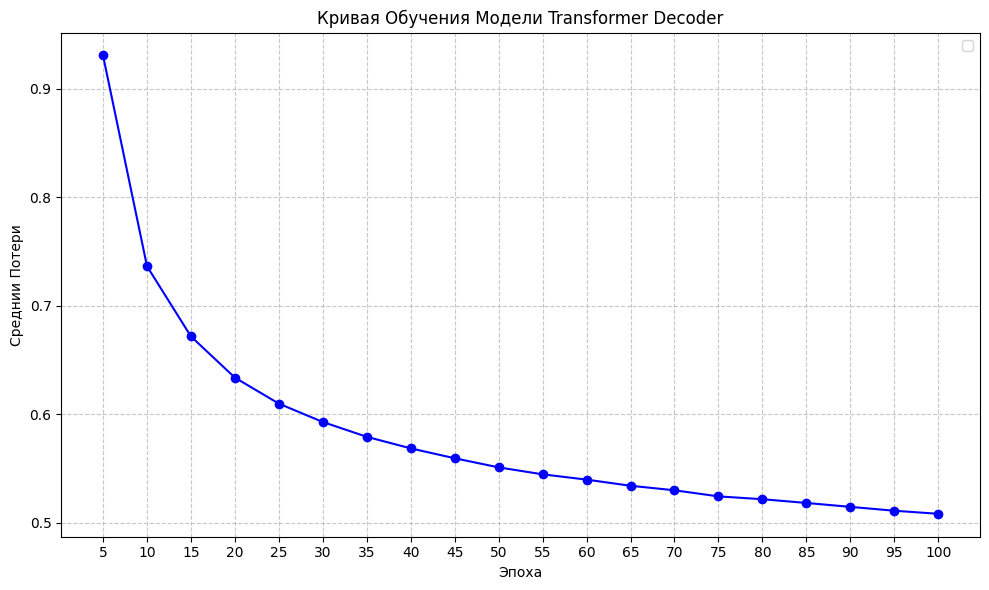

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Автоматическое извлечение данных из результата обучения
epochs = training_history['epochs']
loss_values = training_history['loss']

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', color='blue')
plt.title('Кривая Обучения Модели Transformer Decoder')
plt.xlabel('Эпоха')
plt.ylabel('Среднии Потери')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)
plt.tight_layout()
plt.show()

**generate_text_char**

Функция для последовательной генерации символов.
На каждом шаге модель предсказывает следующий символ, используя всю
ранее сгенерированную последовательность.

---

**Температура (T):**

**Высокое T (T>1)** делает распределение более плоским (более случайная генерация),

**Низкое T (T<1)** делает распределение более резким (более детерминированная генерация).

In [33]:
# Функция генерации текста
def generate_text_char(model, start_char, length, temperature=0.5):
    model.eval() # Режим оценки
    device = next(model.parameters()).device

    # Инициализация с <START> токеном. Модель учится начинать последовательности с <START>
    input_list = [char_to_ix[START_TOKEN], char_to_ix[start_char]]

    # Отключение вычисления градиентов для ускорения и экономии памяти
    with torch.no_grad():
        for _ in range(length):
            # Подготовка входной последовательности
            if len(input_list) > SEQUENCE_LENGTH:
                 # Обрезаем до SEQUENCE_LENGTH если длина превышена
                current_input = input_list[-SEQUENCE_LENGTH:]
            else:
                current_input = input_list

            inputs = make_sequence_tensor(current_input).unsqueeze(0).to(device)

            # Проход через модель
            outputs = model(inputs)

            # Берем прогнозы только для последнего символа в последовательности (это то, что модель предсказывает следующим после current_seq_len-й позиции)
            next_char_logits = outputs[0, -1, :]

            # Контроль случайности через температуру
            outputs_temp = next_char_logits / temperature
            # Преобразование логитов в вероятности
            probabilities = F.softmax(outputs_temp, dim=-1)

            # Выбор следующего символа используется Multinomial Sampling выборка по вероятностям
            next_char_idx = torch.multinomial(probabilities, num_samples=1).item()

            if next_char_idx == char_to_ix[PAD_TOKEN] or next_char_idx == char_to_ix[START_TOKEN]:
                # Остановить генерацию при встрече спец. токена
                break

            input_list.append(next_char_idx)

    # Преобразование индексов обратно в символы (исключая <START> токен)
    generated_text_indices = input_list[1:]
    generated_text = "".join([ix_to_char[i] for i in generated_text_indices])

    # Возврат в режим обучения
    model.train()
    return generated_text

# Запуск Генерации
if corpus_text:
    # START_CHAR = 'п' стартовый символ П
    START_CHAR = 'п'
    # Генерируем 100 символов
    GENERATION_LENGTH = 100
    TEMPERATURE = 0.7

    print(f"\n--- Генерация текста (длина {GENERATION_LENGTH} символов) ---")
    print(f"Стартовый символ: {START_CHAR}")
    print(f"Температура: {TEMPERATURE}")

    generated_text_output = generate_text_char(model, START_CHAR, GENERATION_LENGTH, TEMPERATURE)
    print(f"Сгенерированный текст:\n'{generated_text_output}'")

    # Оценка модели
    if len(cleaned_text) > TEST_FRAGMENT_LENGTH:
        reference_text = cleaned_text[len(cleaned_text)//2 : len(cleaned_text)//2 + TEST_FRAGMENT_LENGTH]

        generated_chars = list(generated_text_output)
        reference_chars = list(reference_text)

        # Метрики BLEU-2 на символах
        bleu_score = calculate_bleu2(reference_chars, generated_chars)

        print("\nУпрощенная количественная оценка")
        print(f"\nСравниваемый фрагмент (Test, {TEST_FRAGMENT_LENGTH} символов):")
        print(f"'{reference_text}'")
        print(f"\nОценка BLEU-2: {bleu_score:.4f}")
    else:
        print("\nУпрощенная количественная оценка")
        print("Невозможно рассчитать BLEU: тестовый корпус слишком мал или пуст.")


--- Генерация текста (длина 100 символов) ---
Стартовый символ: п
Температура: 0.7
Сгенерированный текст:
'продолжал он, снова обратясь к нему, хочешь быть посланником? хочу, отвечал фемистоклюс. умница, душе'

Упрощенная количественная оценка

Сравниваемый фрагмент (Test, 100 символов):
'кие вершины. под двумя из них видна была беседка с плоским зеленым куполом, деревянными голубыми кол'

Оценка BLEU-2: 0.3905


**BLEU (Bilingual Evaluation Understudy)** — это одна из самых старых и наиболее распространенных метрик для количественной оценки качества машинного перевода, а также для оценки систем генерации текста (например, суммаризации или, в вашем случае, языкового моделирования).

Ее главная **цель** — измерить степень сходства между сгенерированным (предсказанным) текстом и одним или несколькими эталонными (референсными) текстами.

Оценка $0.3905$ означает что:
1. Оценка далека от $0.0$, что говорит о том, что модель успешно освоила алфавит, общие орфографические паттерны, знаки препинания и, вероятно, структуру коротких часто встречающихся "слов"
2. Для генерации осмысленного и беглого текста на уровне символов, где каждая ошибка в букве может разорвать биграмму, оценка $0.39$ указывает на то, что модель действительно научилась правильно писать слова, а не просто рандомно их генерировать.
3. Высокая оценка BLEU-2 не гарантирует, что сгенерированный текст является осмысленным или грамматически правильным на уровне предложений. Модель могла просто хорошо имитировать последовательности букв.